### Always to run stuff

In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
# from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [4]:
from video_pipeline.video_module import *

In [5]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


In [6]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

# test_dataset = Stack_dataset(jn(output_path, 'test'), jn(input_path, 'test'), frames_number,
#                              frames_interval)
# train_dataset = Stack_dataset(jn(output_path, 'train'), jn(input_path, 'train'), frames_number,
#                               frames_interval)

def get_elemenst_from_dataset(slice, key_id=10):
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [7]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)
# import torch_real_sim_lib as trsl
# new_sim = trsl.FiberSimulator(config)
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)


In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

### Клетка для запуска.

## End of always run stuff.
## Beginning of code.

### Загрузка лога хорошего протыкивания

In [18]:
!wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" -O cert.crt -q
import os
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


try:
    import dotenv
    dotenv.load_dotenv()
except ImportError:
    pass

client = pymongo.MongoClient(
    host=os.environ['host'],
    port=27018,
    replicaSet='rs01',
    username=os.environ['username'],
    password=os.environ['password'],
    authSource=os.environ['database'],
    tls=True,
    tlsCAFile='cert.crt'
)
db = client[os.environ['database']]

In [19]:
from scipy.interpolate import interp1d

def interplating_parser(target_tenso_signal, subtracting_first=True):
    def log_pars_func(point_res_dict):
        '''Returns signal(target_tenso_signal) value gotten by interpolation'''
        x = np.array(point_res_dict['tenso_signal'])
        y = np.array(point_res_dict['final_power'])
        y = y[x != None]
        x = x[x != None]
        if subtracting_first:
            x = [t - x[0] for t in x]
        x = [float(t) for t in x]
        x = x + np.random.normal(0, 0.0001, len(x))     # чтобы не было совпадений по x
        interpolated_function = interp1d(x, y, kind='linear', fill_value='extrapolate')
        return 1 - interpolated_function(target_tenso_signal)/y[0]
    return log_pars_func
log_pars_func = interplating_parser(15)


In [20]:
# def log_pars_func(point_res_dict):
#     '''Returns max(absolute value) force'''
#     return np.abs(point_res_dict['final_power']).min()
    
def sensor_plotting(points_curves, log_parser_function, vis='hist2d', hist2d_kwargs={}):
    '''Plots 3d or heatmap visualization of spatial characteristics of sensor
    log_parser_function(dict_with_results_in_one_point) -> 1d value to visualize
    example:
    def log_pars_func(point_res_dict):
        """Returns max(absolute value) force"""
        return np.abs(point_res_dict['force_z']).max()
        
    '''
    X = []
    Y = []
    Z = []
    for point_res in points_curves:
        xy = point_res['relative_coordinate']
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(log_parser_function(point_res))
    
    if vis == "scatter":
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    #     ax.plot_surface(np.array(X).reshape(-1, 1)), np.array(Y).reshape(1, -1), np.array(Z).reshape())
        ax.scatter(np.array(X), np.array(Y), np.array(Z))
        # plt.hexbin(np.array(X), np.array(Y), np.array(Z), gridsize=(10, 2))
    elif vis == 'hist2d':
        xs = set(X)
        ys = set(Y)
        shape = (len(xs), len(ys))
        plt.hist2d(np.array(X), np.array(Y), weights=np.array(Z), bins=shape, **hist2d_kwargs)
        


In [21]:
id = 727
points_curves_1 = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
points_curves_1 = [point_res for point_res in points_curves_1 if point_res['relative_coordinate'][0] < 16.45]
id = 728
points_curves_2 = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
points_curves = points_curves_1 + points_curves_2

tenso_target = 10
log_pars_func = interplating_parser(tenso_target, subtracting_first=True)

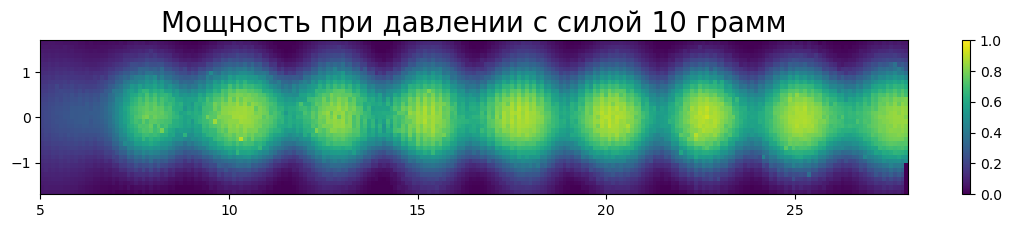

In [22]:

plt.figure(figsize=(14, 2))
sensor_plotting(points_curves, log_pars_func, hist2d_kwargs={"vmin": 0, "vmax": 1} )
plt.colorbar()
plt.title(f"Мощность при давлении с силой {tenso_target} грамм", fontsize=20);

## Установка правильных параметров в конфиг.

In [23]:
config['env']['sen_geometry']['n_angles'] = 1

In [24]:
config['env']['sen_geometry']['distance'] = 0.1
assert(config['env']['phys']['sigma']==1)
config['env']['phys']['sigma'] = 1

In [25]:
config['env']['bimodal']['borning_modes'] = [1, 0]
config['env']['bimodal']['impact_modes'] = [1, 1]

In [26]:
config['env']['bimodal']['period'] = 2.5

экспериментальный график

In [27]:
rel_y = 0.6
filtered_points = [t for t in points_curves if abs(t['relative_coordinate'][1]-rel_y)<0.05]

In [28]:
N = 8

In [30]:
sinus_range = [10, 23]

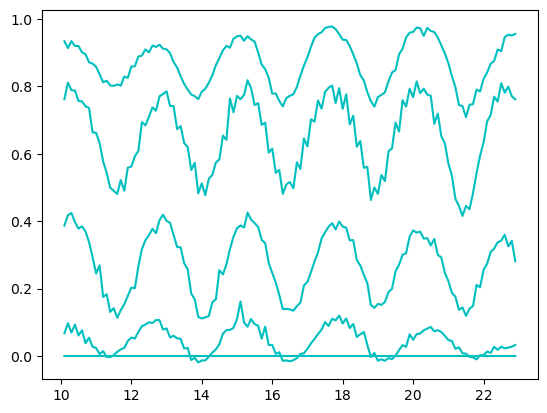

In [58]:
def plot_exp(N, filtered_points):
    for tenso_target in np.linspace(0, 14, N):
        log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
        Y = []
        signals = []
        for point_res in filtered_points:
            Y.append(point_res['relative_coordinate'][0])
            signals.append(log_pars_func(point_res))
        plt.plot(Y, signals, 'c')
    return Y

filt_points_2 = [x for x in filtered_points if sinus_range[0] < x['relative_coordinate'][0] < sinus_range[1]]
plot_exp(N, filt_points_2);

симулированный график

In [31]:
indent = 40

def gen_point_pres(x):
    d = 1
    point_pres = np.zeros((111, d), dtype=np.float32)
    point_pres[x, d//2] = 1*0.04 * 40       # firstly for gaus blur. Secondly for force equality
    return point_pres
point_pres = gen_point_pres(35)

dataset_point_presses = np.zeros((point_pres.shape[0]-2*indent,) + point_pres.shape, dtype=np.float32)
for i in range(indent, point_pres.shape[0]-indent):
    dataset_point_presses[i-indent] = gen_point_pres(i)
dataset_X = np.linspace(0, dataset_point_presses.shape[0]*0.1, dataset_point_presses.shape[0], endpoint=False)

In [32]:
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)

In [33]:
config['env']['bimodal']['intermode_matrix'] = [[1, 0], 
                                                [1, 1]]
simb = tbsl.FiberSimulator(config)

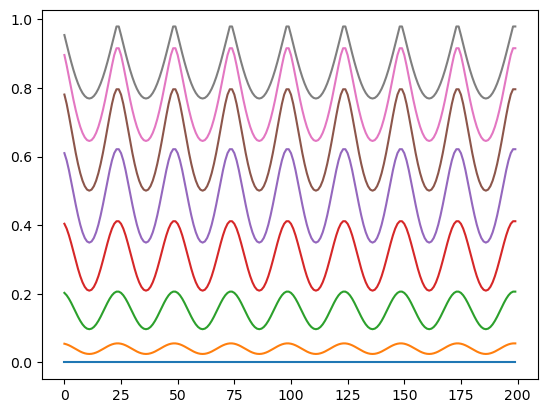

In [37]:
for amplitude in np.linspace(0, 14, N):
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    plt.plot(np.concatenate([sinus[0:25] for i in range(8)]))

In [59]:
def plot_sim(N, x_data, x_shift):
    
    for amplitude in np.linspace(0, 14, N):
        result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
        sinus = result_numbers[:, 0, result_numbers.shape[-1]//2][0:25]
        
        point_counter = 0
        sinuses = []
        while point_counter < len(x_data)+x_shift:
            sinuses.append(sinus)
            point_counter+= len(sinus)
        
        plt.plot(x_data, np.concatenate(sinuses)[x_shift:x_shift+len(x_data)], 'g', label="sim")

merge plots

In [63]:
N = 8

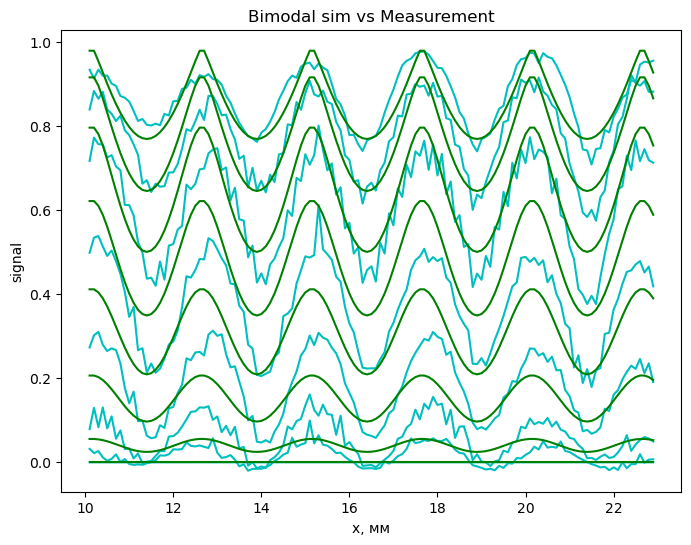

In [65]:
plt.figure(figsize=(8, 6))
X = plot_exp(N, filt_points_2)
plot_sim(N, X, 23)
# plt.legend(["sim", 'real'])
plt.title("Bimodal sim vs Measurement")
plt.ylabel("signal")
plt.xlabel("x, мм")
None

другие параметры симуляции.

In [66]:
config['env']['bimodal']['intermode_matrix'] = [[8.83458646e-01, 9.15247256e-20], [9.73792396e-01, 9.95924965e-01]]
simb = tbsl.FiberSimulator(config)

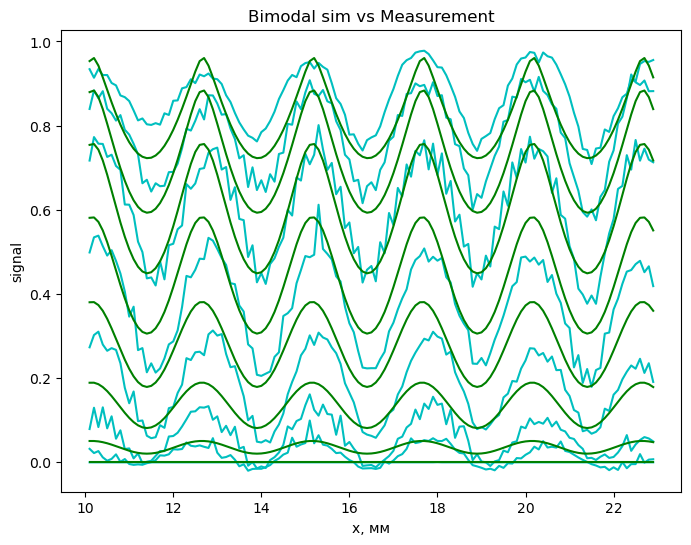

In [67]:
plt.figure(figsize=(8, 6))
X = plot_exp(N, filt_points_2)
plot_sim(N, X, 23)
# plt.legend(["sim", 'real'])
plt.title("Bimodal sim vs Measurement")
plt.ylabel("signal")
plt.xlabel("x, мм")
None